# Linear Regression

In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import pandas as pd
from joblib import dump
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.regression_metrics import regression

Data loading:

In [2]:
train =  pd.read_parquet('../../../data/model_input/train_sets/superconductivity.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/superconductivity.parquet')

In [3]:
y_train = train.critical_temp
X_train = train.drop(columns=['critical_temp'])

In [4]:
y_validation = validation.critical_temp
X_validation = validation.drop(columns=['critical_temp'])

We are going to compute three type of models: Ordinary Least Squares Linear Regression, Ridge ($l_2$ penalty term), Lasso ($l_1$ penalty term) and ElasticNet (convex combination of Ridge and Lasso).

In [7]:
scaler = StandardScaler().fit(X_train, y_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [9]:
lr = LinearRegression()
lr_l2 = Ridge()
lr_l1 = Lasso()
lr_en1 = ElasticNet(l1_ratio=0.25)
lr_en2 = ElasticNet(l1_ratio=0.5)
lr_en3 = ElasticNet(l1_ratio=0.75)

In [10]:
models_list = [lr, lr_l2, lr_l1, lr_en1, lr_en2 , lr_en3]
names_list = ['LR', 'LR_l2', 'LR_l1', 'LR_en_0.25', 'LR_en_0.5', 'LR_en_0.75']

In [11]:
metrics = regression(models_list, names_list, '../../../data/model_output/metrics/superconductivity/linear_regression.csv', X_train_scaled, y_train, X_validation_scaled, y_validation, metrics={})
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
LR,0.223495,16.325260,52.692646,222.767568
LR_l2,0.038895,16.334652,51.203038,213.462675
LR_l1,0.652768,18.662685,35.032807,87.715793
LR_en_0.25,1.949381,19.232398,32.589430,69.450686
LR_en_0.5,1.645008,19.166251,32.805209,71.161323
LR_en_0.75,0.989353,18.977686,33.835927,78.293222


The ordinary and the Ridge models are way overfitted. The other four models are also quite overfitted but not that much.

In [14]:
sparsity = [np.mean(mod.coef_.ravel() == 0)*100 for mod in models_list]

print("Sparsity without penalty term:", round(sparsity[0], 2), '%')
print("Sparsity with L2 penalty:", round(sparsity[1], 2), '%')
print("Sparsity with L1 penalty:", round(sparsity[2], 2), '%')
print("Sparsity with ElasticNet penalty and l1 ratio=0.25:", round(sparsity[3], 2), '%')
print("Sparsity with ElasticNet penalty and l1 ratio=0.5:", round(sparsity[4], 2), '%')
print("Sparsity with ElasticNet penalty and l1 ratio=0.75:", round(sparsity[5], 2), '%')

Sparsity without penalty term: 1.8 %
Sparsity with L2 penalty: 5.39 %
Sparsity with L1 penalty: 86.23 %
Sparsity with ElasticNet penalty and l1 ratio=0.25: 33.53 %
Sparsity with ElasticNet penalty and l1 ratio=0.5: 53.89 %
Sparsity with ElasticNet penalty and l1 ratio=0.75: 71.26 %


We are going to choose **LR_en_0.5** because it gets the second lowest Validation RMSE (very close to the lowest one) and the second best delta. Also it makes half of the coefficients zero.

In [5]:
test =  pd.read_parquet('../../../data/model_input/test_sets/superconductivity.parquet')

In [6]:
y_test = test.critical_temp
X_test = test.drop(columns=['critical_temp'])

In [7]:
retrain = pd.concat([train, validation])

In [8]:
y_retrain = retrain.critical_temp
X_retrain = retrain.drop(columns=['critical_temp'])

In [9]:
scaler_retrain = StandardScaler().fit(X_retrain, y_retrain)

In [10]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [13]:
model = ElasticNet(l1_ratio=0.5).fit(X_retrain_scaled, y_retrain)

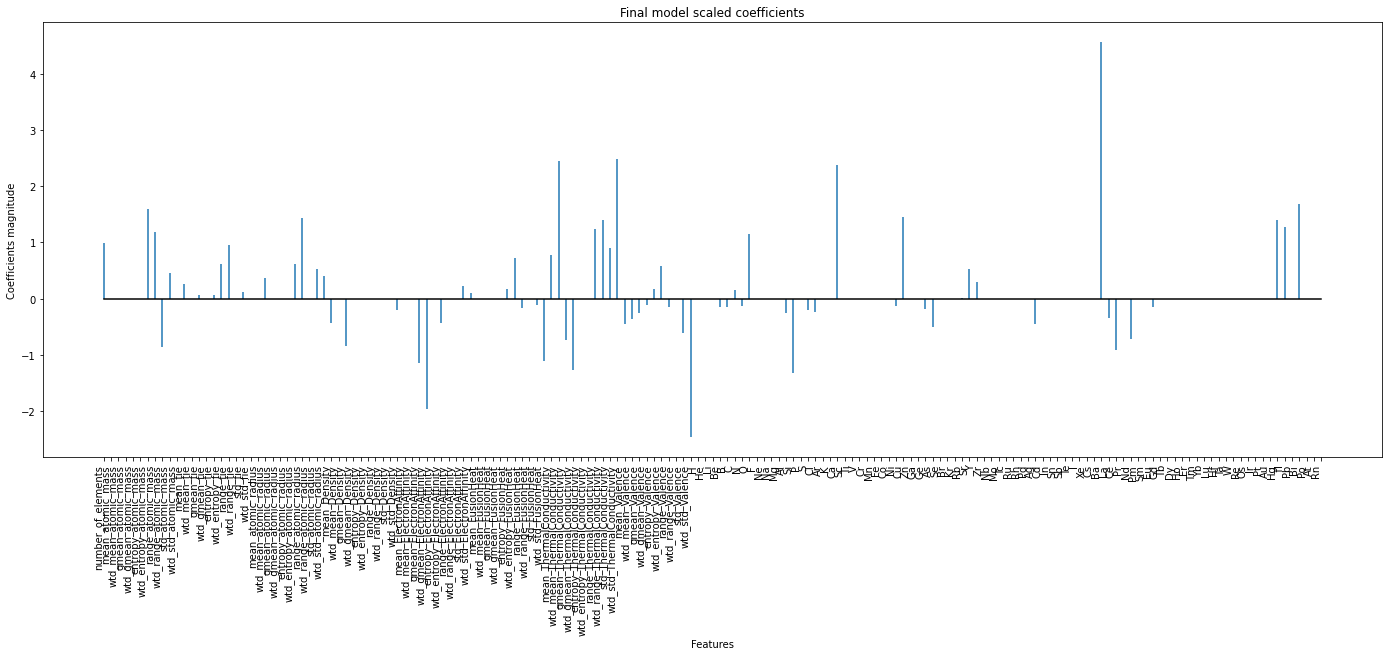

In [29]:
fig, ax = plt.subplots(figsize=(24, 8))
ax.stem(X_retrain.columns, model.coef_.ravel(), markerfmt=' ', basefmt='k-')
plt.xticks(rotation=90, ha='right')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Final model scaled coefficients');

In [30]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 20.0581


Super nice, we got a new model that works much better thanks to the extra amount of training data.

In [14]:
dump(model, '../../../data/model_output/models/superconductivity/best_linear_regression.joblib')

['best_linear_regression.joblib']

In [35]:
with open('../../../data/model_output/metrics/superconductivity/final_RMSE.txt', 'a') as f:
    f.write('\nLR, '+ str(rmse))

## Residuals diagnosis

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_16080/2975082643.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],
C:\aaa\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


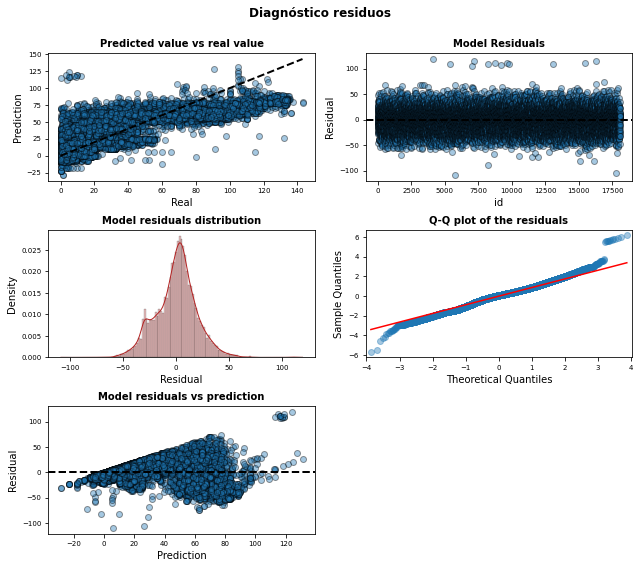

In [17]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_retrain, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Predicted value vs real value', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Prediction')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_retrain))), error_retrain,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Model Residuals', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residual')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = error_retrain,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Model residuals distribution', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residual")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    error_retrain,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q plot of the residuals', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediction_retrain, error_retrain,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Model residuals vs prediction', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Prediction')
axes[2, 0].set_ylabel('Residual')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

Residuals are not distributed normally. The model doesn't predict well at the minimum and maximum values of the target.

In [11]:
from joblib import load
load_mod = load('../../../data/model_output/models/superconductivity/best_linear_regression.joblib')

train_pred = load_mod.predict(X_retrain_scaled)
rmse_train = root_mean_squared_error(y_retrain, train_pred)
test_pred = load_mod.predict(X_test_scaled)
rmse_test = root_mean_squared_error(y_test, test_pred)

In [12]:
import time 
time1 = time.time()
ElasticNet(l1_ratio=0.5).fit(X_retrain_scaled, y_retrain)
time2 = time.time() - time1 

with open('../../../data/model_output/metrics/superconductivity/final_metrics.txt', 'a') as f:
     f.write(f'\nLR; {time2}; {rmse_train}; {rmse_test}')